In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-clustering/customer_segmentation.csv
/kaggle/input/customer-personality-analysis/marketing_campaign.csv


# *IMPORTING LIBRARIES*

In [45]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [46]:
data = pd.read_csv("/kaggle/input/customer-personality-analysis/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [48]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [49]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [50]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [51]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [52]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [53]:
data.describe()


,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

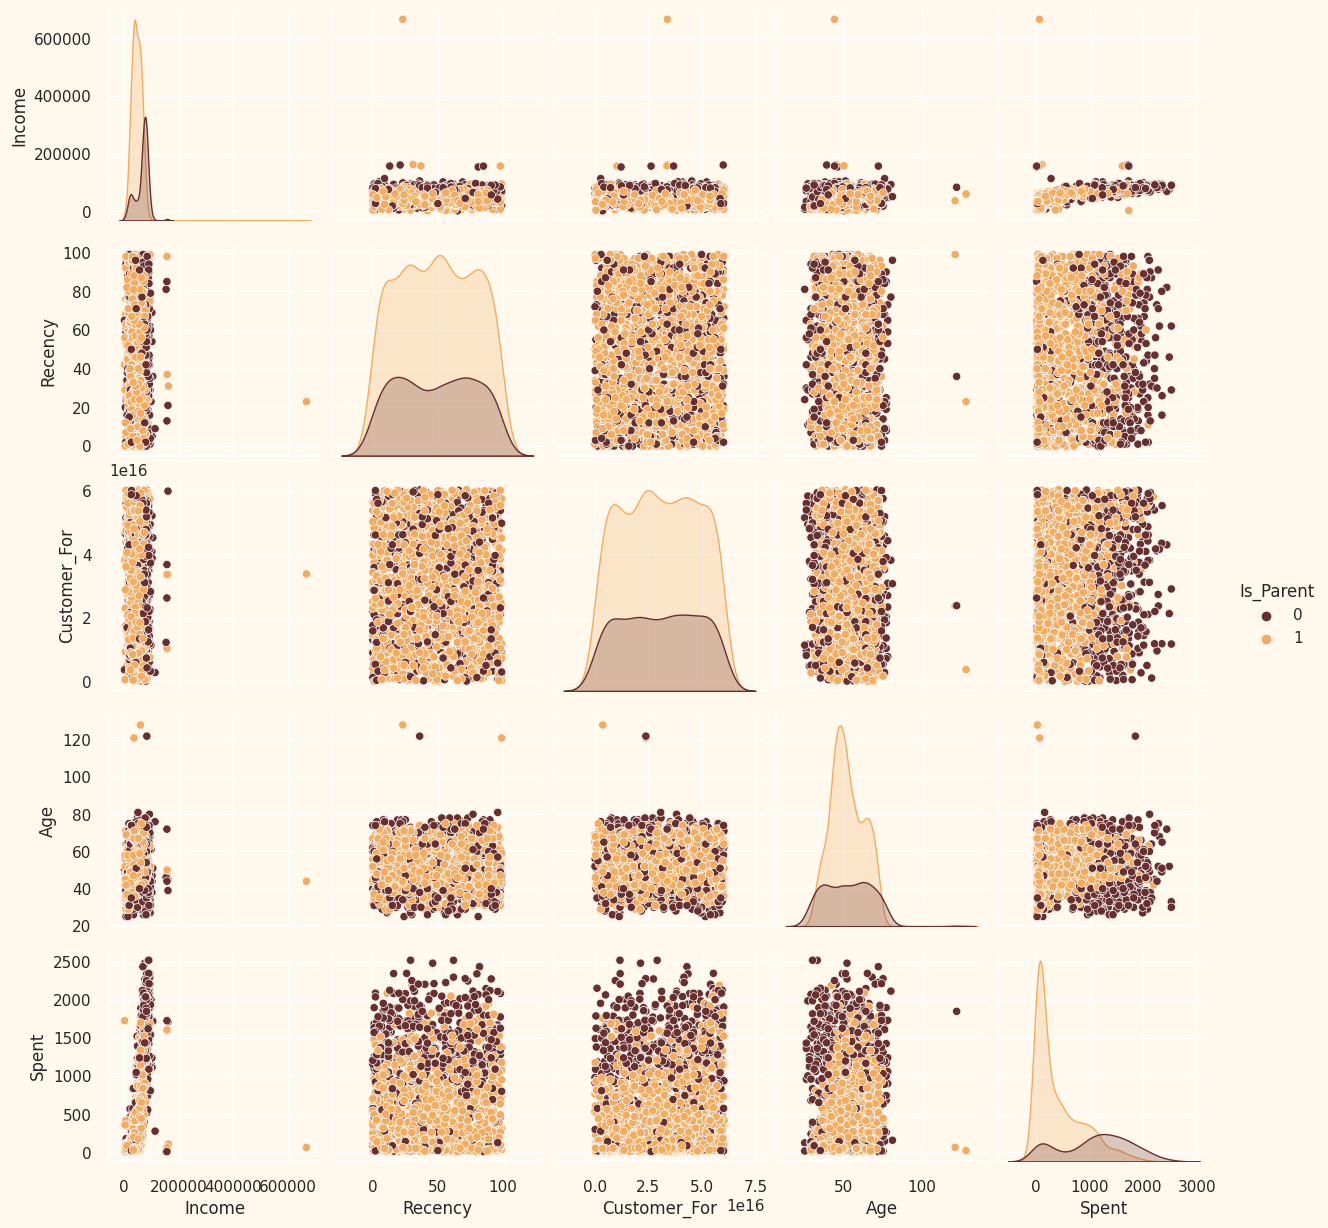

In [54]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [55]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


<Axes: >

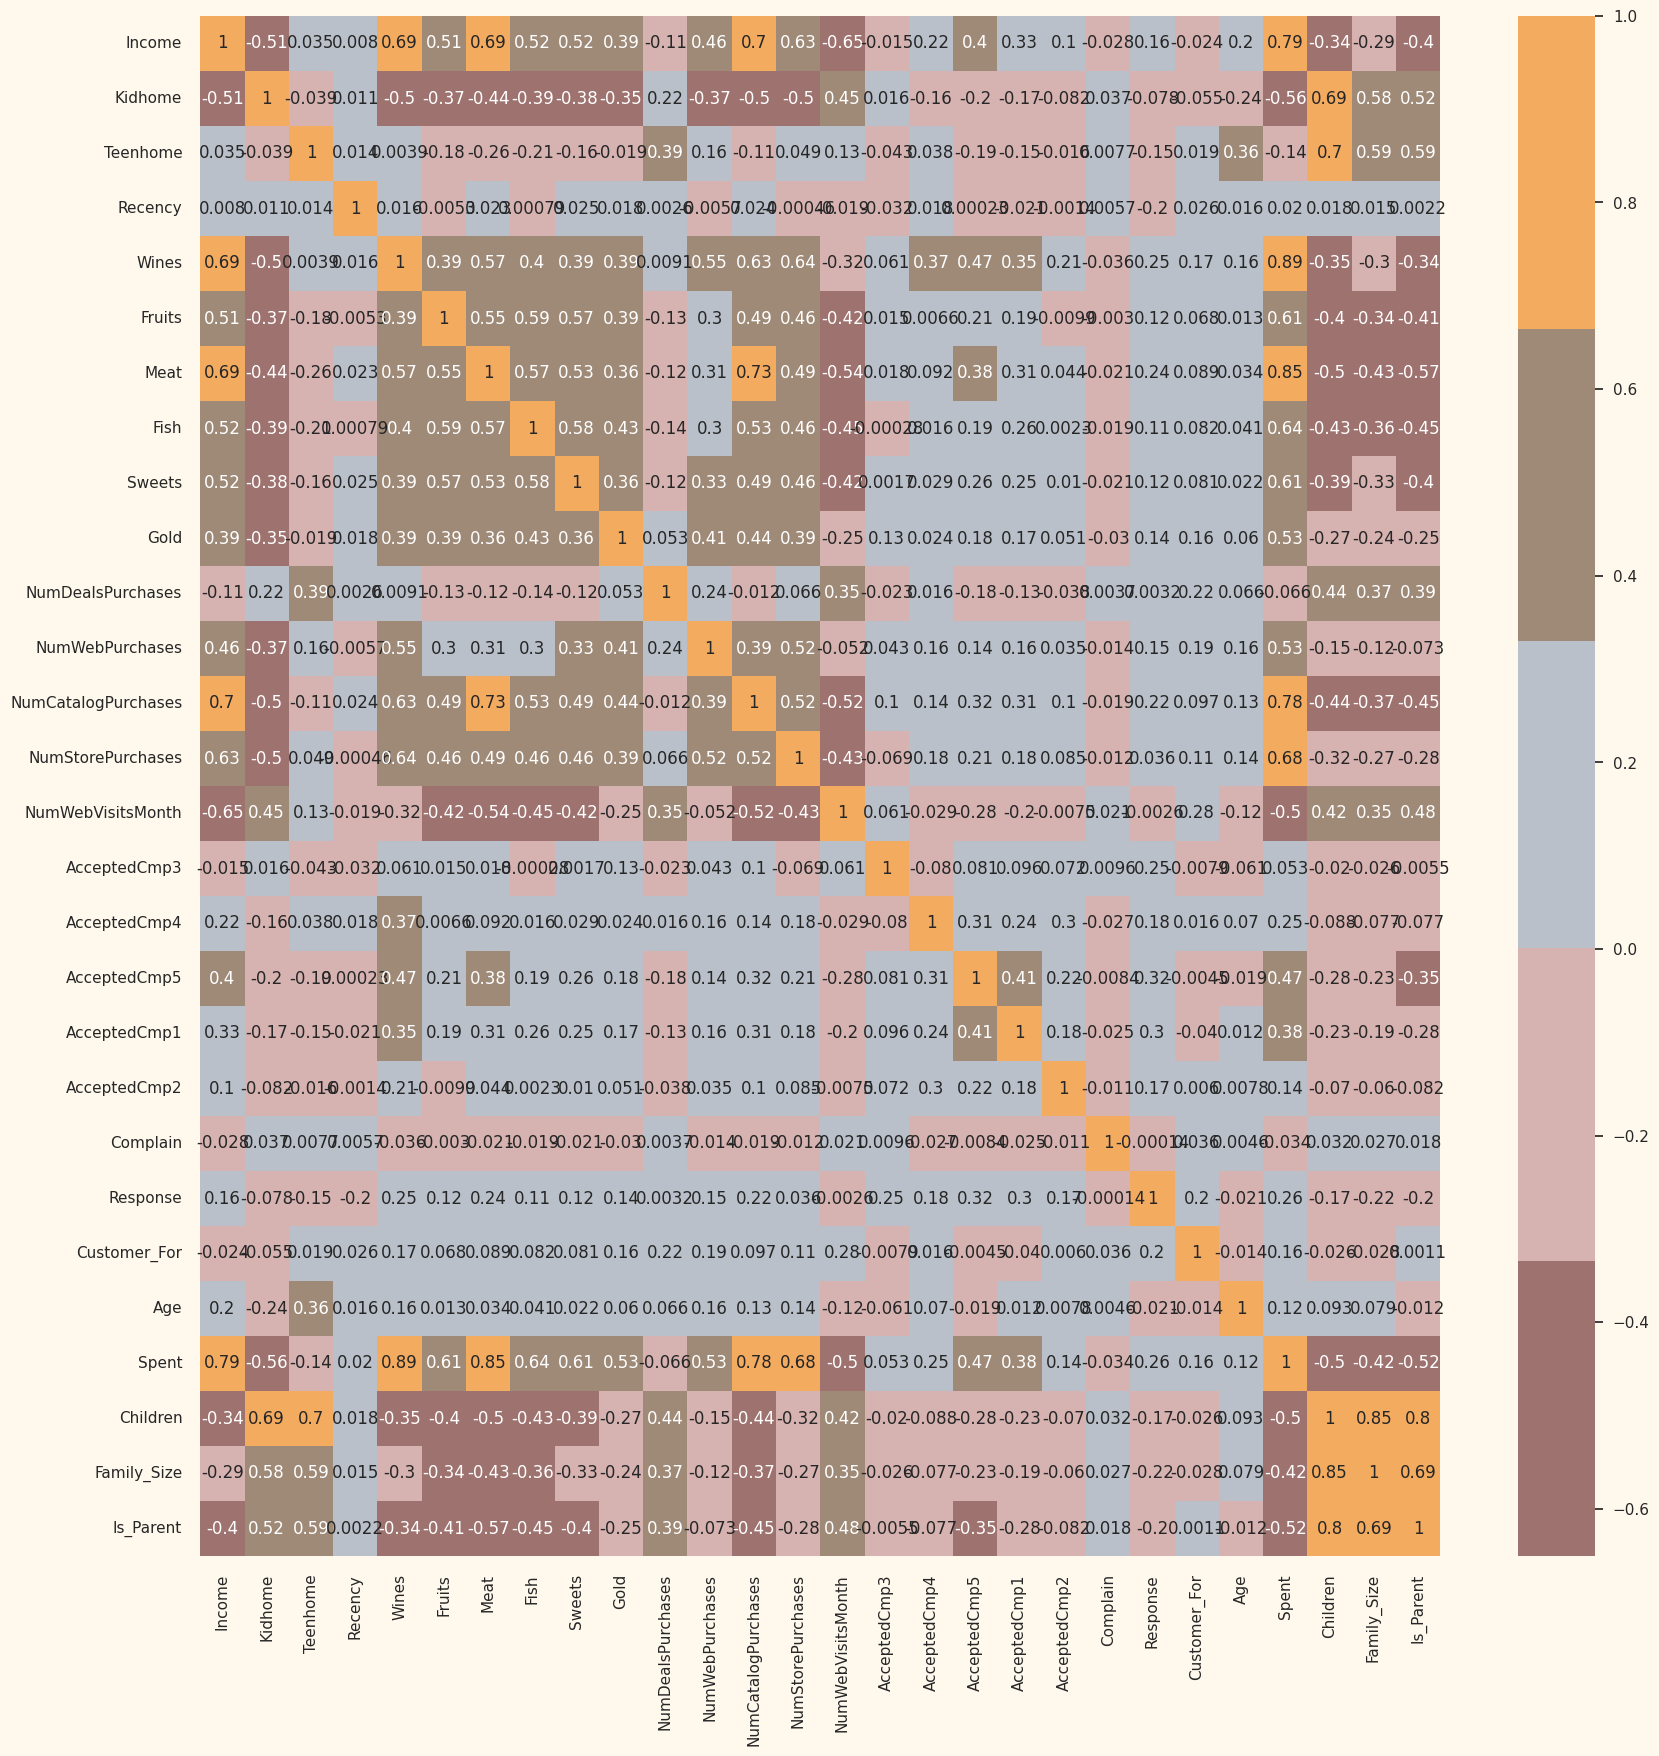

In [56]:
#correlation matrix
corrmat = data.corr(numeric_only=True)
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)

# *DATA PREPROCESSING*

In [57]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [58]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [59]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
cols_del = ['Kidhome', 'Teenhome', 'Is_Parent','Living_With', 'Education']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [60]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Children,Family_Size
0,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.264598,-1.758359
1,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,1.404572,0.449070
2,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,-1.264598,-0.654644
3,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.069987,0.449070
4,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.069987,0.449070


# *DIMENSIONALITY REDUCTION*

In [61]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-2.248553e-17,2.705212,-5.648014,-2.398294,-0.812656,2.357906,7.344110
col2,2212.0,2.890997e-17,1.453622,-3.596880,-1.069937,-0.189668,0.890911,6.145305
col3,2212.0,3.372829e-17,1.159007,-3.723350,-0.786679,-0.011252,0.778543,5.700317


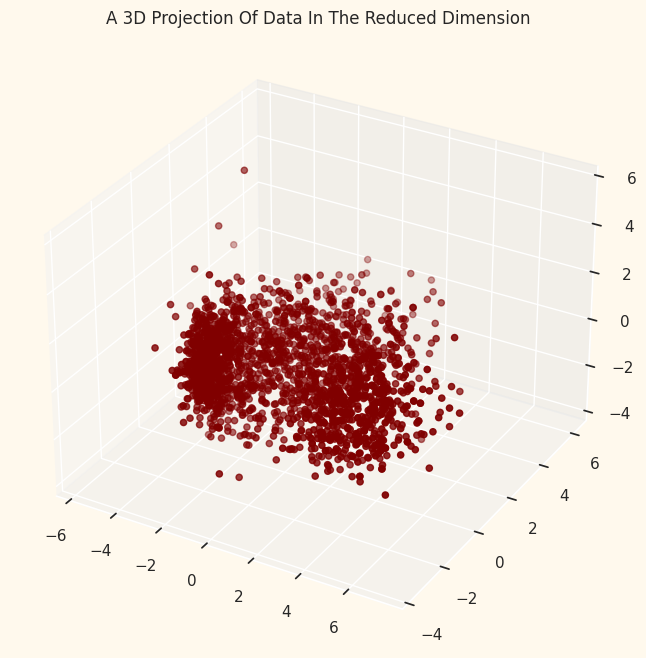

In [62]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

<Axes: >

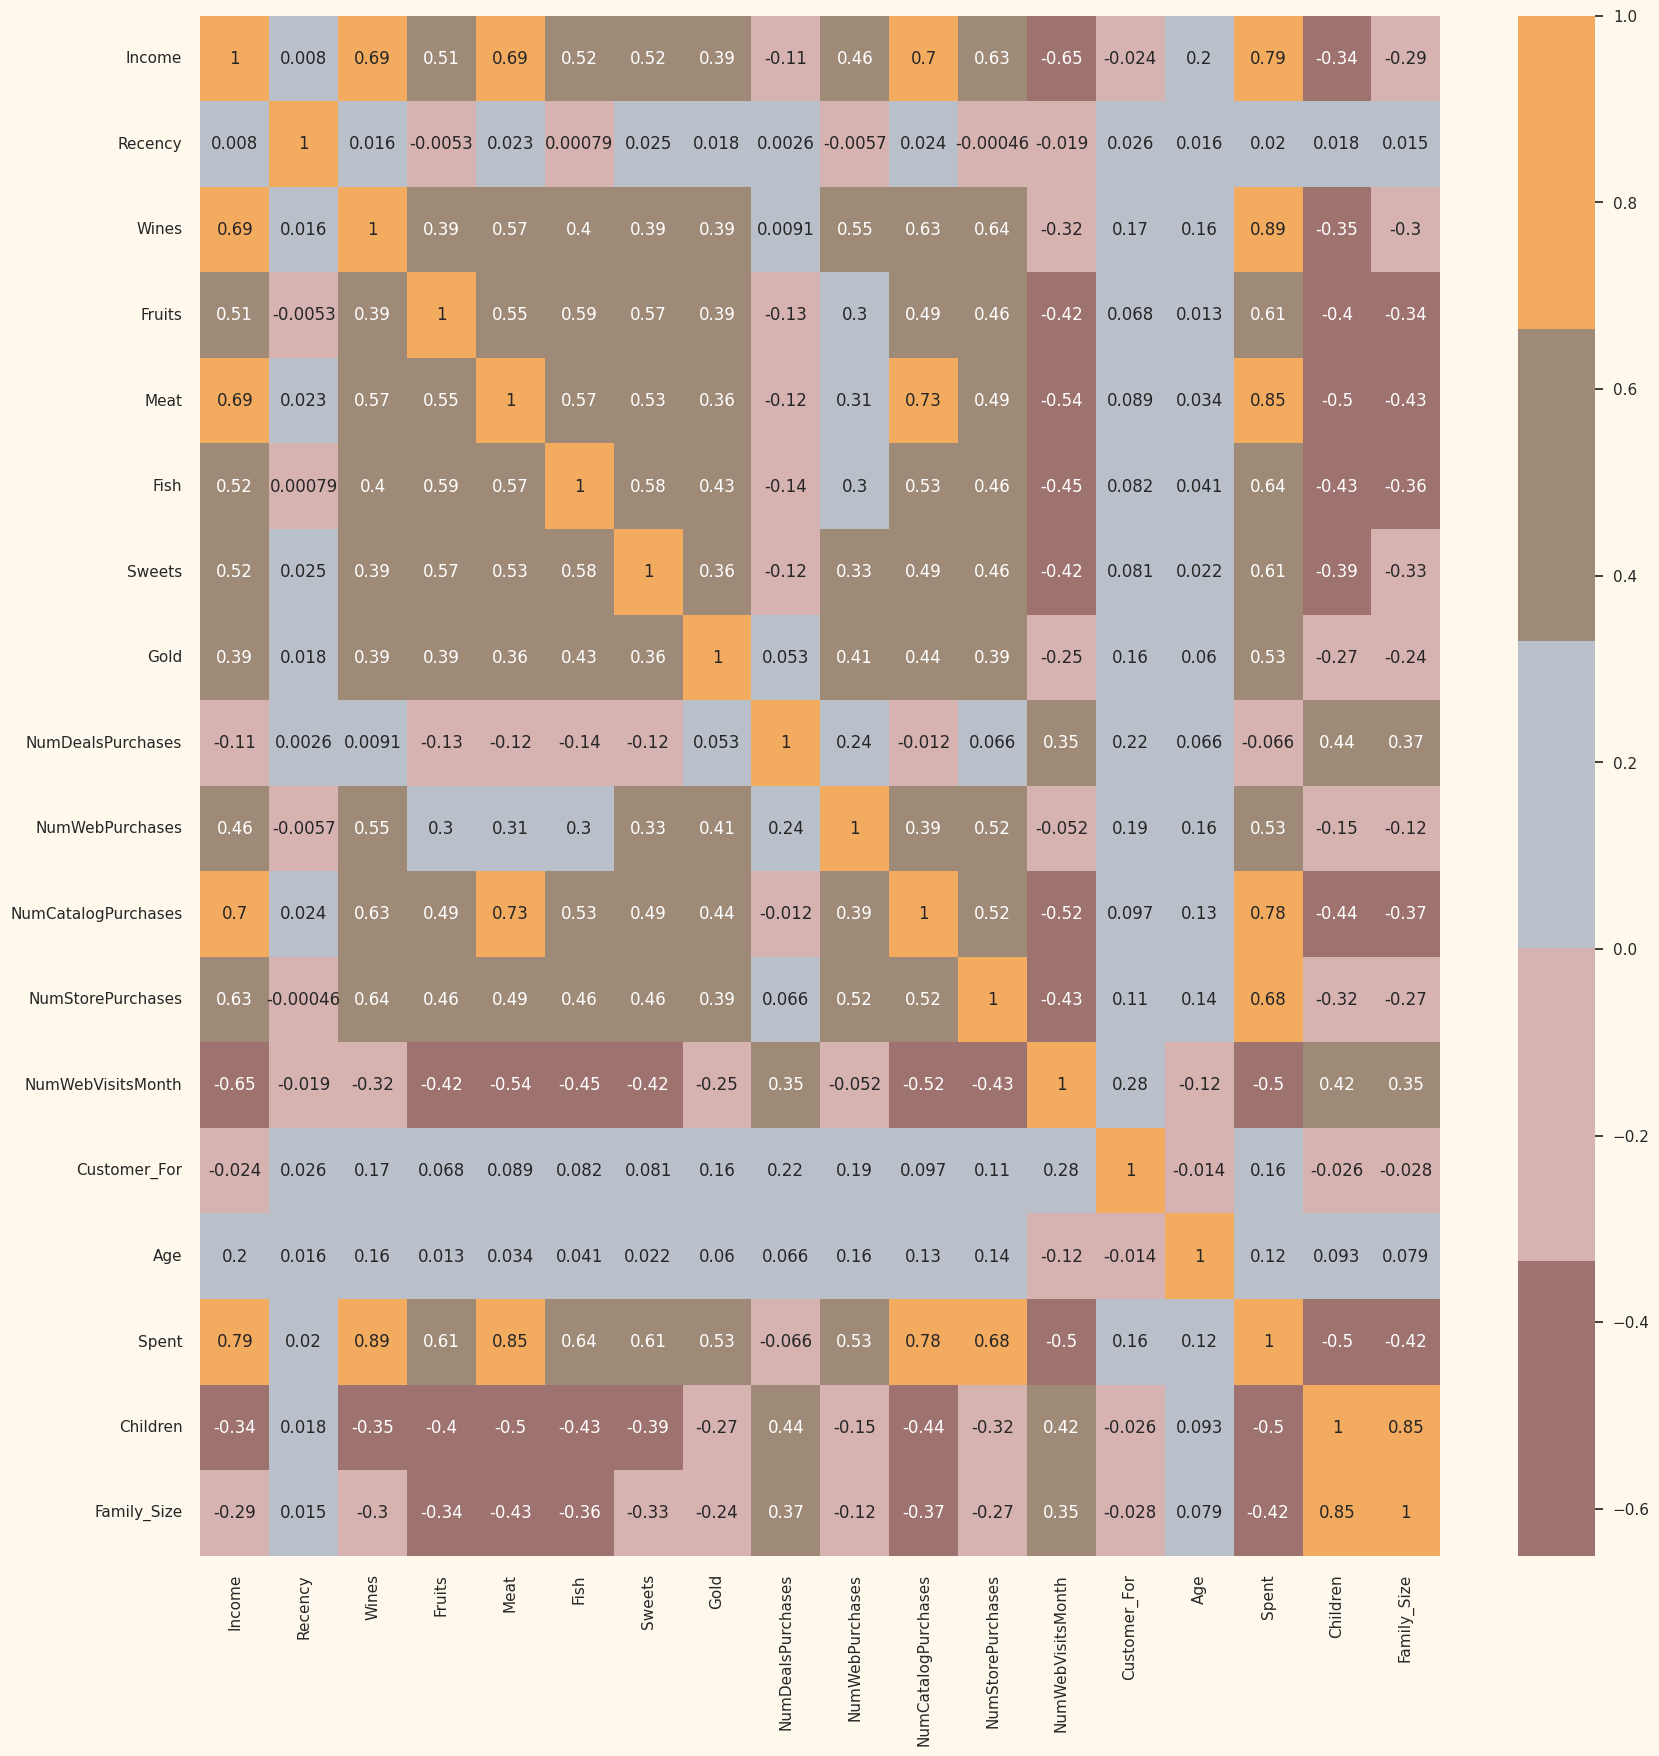

In [63]:
#correlation matrix
corrmat = ds.corr(numeric_only=True)
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)

# *CLUSTERING*

Elbow Method to determine the number of clusters to be formed:


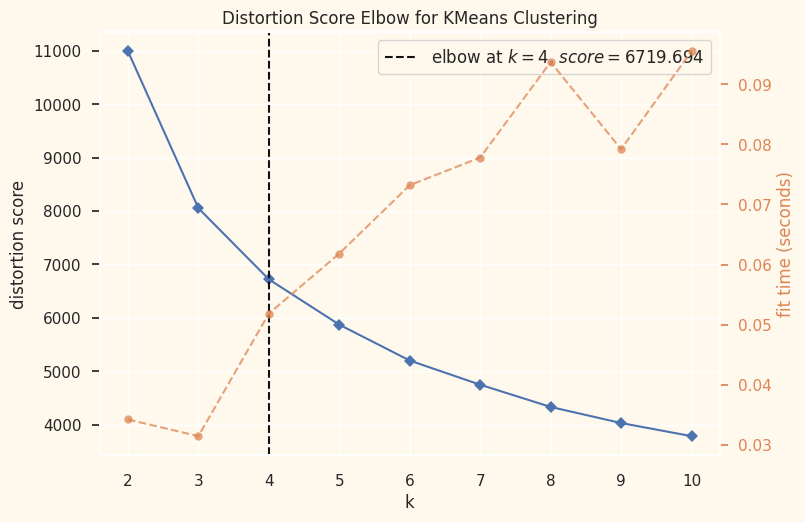

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [64]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [65]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

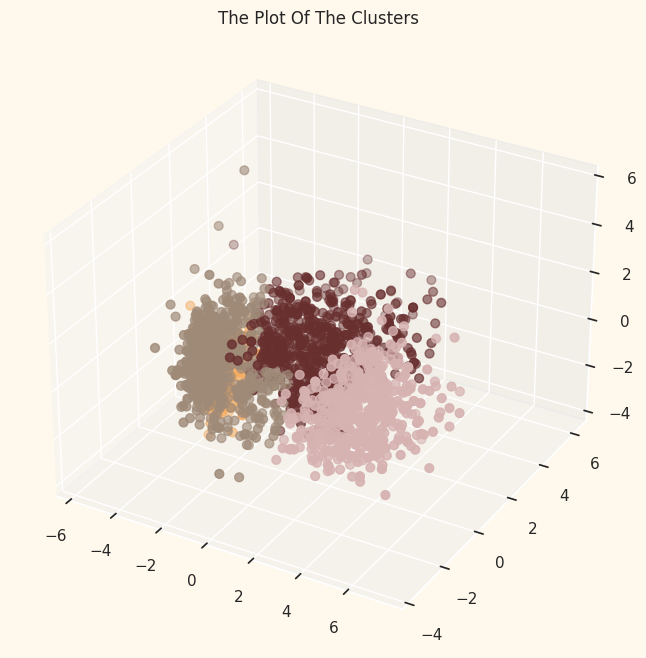

In [66]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

# *EVALUATING MODELS*

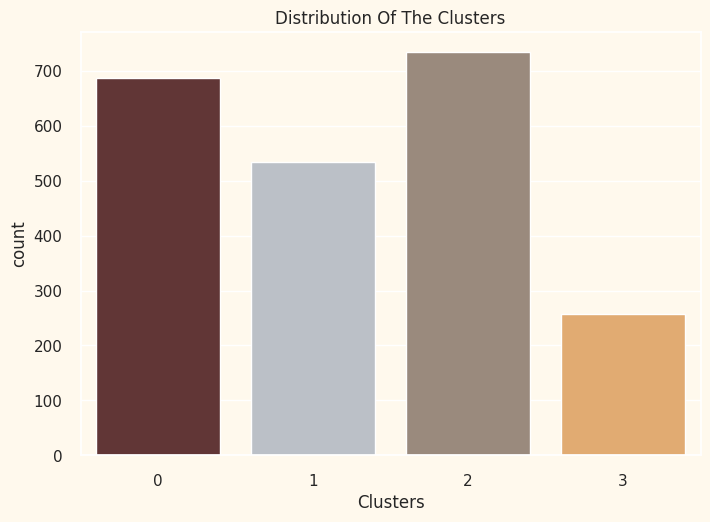

In [67]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

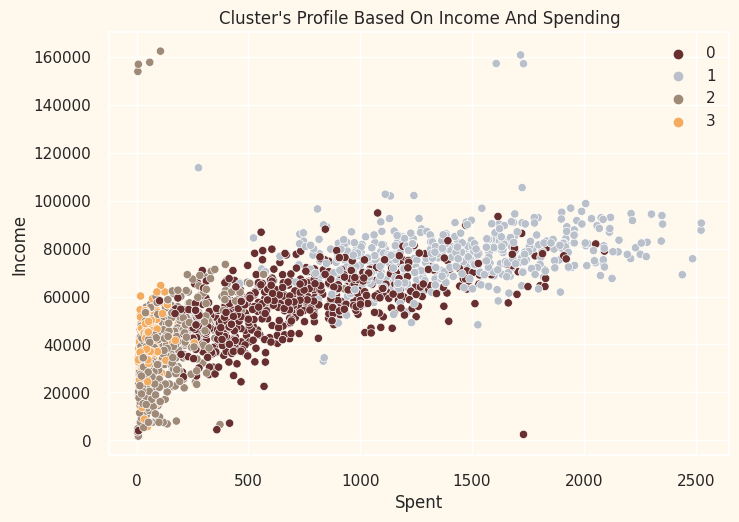

In [68]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

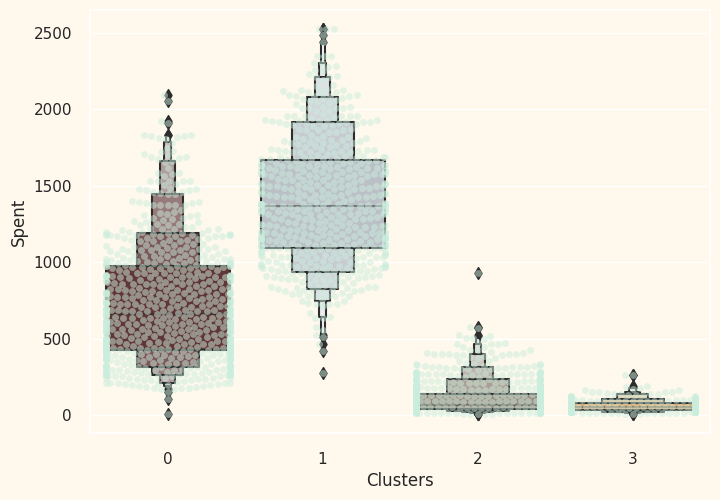

In [69]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

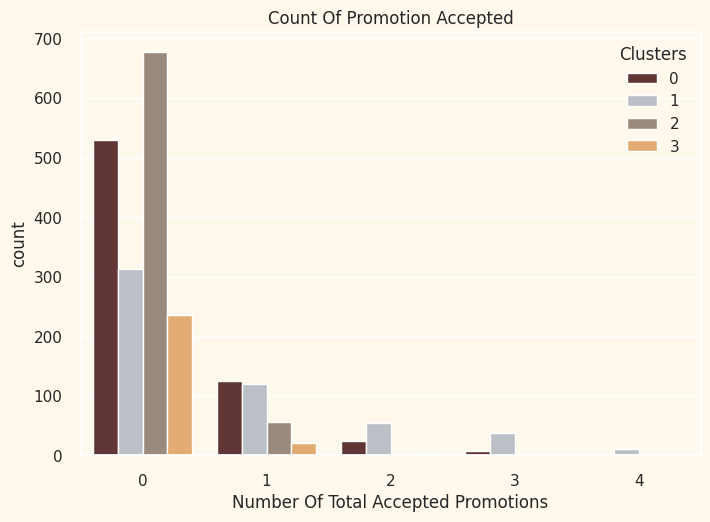

In [70]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

# ***Import All Required Libraries***

In [71]:
# === Core Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Preprocessing ===
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# === Metrics for Evaluation ===
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# === Utilities ===
import random
import warnings
warnings.filterwarnings("ignore")


In [72]:
#Global Parameters
POP_SIZE = 50           # Number of individuals in each generation
TOURNAMENT_SIZE = 3     # For tournament selection
MUTATION_RATE = 0.3    # Mutation probability

# Number of clusters to use in all clustering algorithms
N_CLUSTERS =2
# Population size for Memetic Algorithm
POPULATION_SIZE = 100

# Number of generations for Memetic Algorithm
N_GENERATIONS = 30

# Random seed to ensure reproducibility
RANDOM_SEED = 42

# Local search iterations (for hill-climbing or greedy improvements)
LOCAL_SEARCH_ITERATIONS =5


# ***Implementing the Memetic Algorithm***


In [73]:
#Initialize the Population
def initialize_population(X, n_clusters=4, population_size=10, seed=None):
    """
    Randomly initializes a population of cluster centers.

    Parameters:
        X (ndarray): The input dataset.
        n_clusters (int): Number of clusters to form.
        population_size (int): Number of individuals (solutions) in the population.
        seed (int): Random seed for reproducibility.

    Returns:
        population (list of ndarrays): A list of candidate cluster center sets.
    """
    if seed is not None:
        np.random.seed(seed)

    population = []

    for _ in range(population_size):
        # Randomly pick cluster centers from the dataset
        indices = np.random.choice(len(X), n_clusters, replace=False)
        cluster_centers = X[indices]
        population.append(cluster_centers)

    return population


In [74]:
# Convert your scaled dataframe to NumPy array
X = scaled_ds.values

# Create initial population
population = initialize_population(X, n_clusters=N_CLUSTERS, population_size=POPULATION_SIZE, seed=RANDOM_SEED)

# Show first individual (cluster centers)
print("Sample individual (first solution):\n", population[0])


Sample individual (first solution):
 [[ 0.48745416  0.41402824  0.62183704  0.52020634  0.44588969  0.44469359
   0.9481943  -0.11463054 -0.16870113  0.33259976  0.79530347 -0.55581429
  -0.95727093 -0.88770105  0.84739656  0.64366969  0.06998729 -0.65464433]
 [-0.68411526  0.65593659 -0.84593129 -0.61229457 -0.70484907 -0.61448044
  -0.51230994 -0.46282472 -0.68843217 -1.12641992 -0.57133959 -1.17116024
  -0.54490807 -1.01612838 -1.28954674 -0.90685392  0.06998729  0.44907004]]


In [75]:
#Assign Points to Nearest Cluster & Compute Fitness
from sklearn.metrics import silhouette_score

def assign_clusters(X, centers):
    """
    Assigns each data point to the nearest cluster center.

    Parameters:
        X (ndarray): The dataset (n_samples × n_features).
        centers (ndarray): Cluster centers (n_clusters × n_features).

    Returns:
        labels (ndarray): Array of cluster labels for each point.
    """
    # Compute distance from each point to each cluster center
    distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
    # Assign to the nearest cluster center
    labels = np.argmin(distances, axis=1)
    return labels

# === Fitness Function ===
def calculate_fitness(X, centers):
    """
    Calculates the fitness (quality) of a clustering solution using silhouette score.

    Parameters:
        X (ndarray): The dataset.
        centers (ndarray): Cluster centers.

    Returns:
        float: Fitness score (higher is better).
    """
    labels = assign_clusters(X, centers)
    if len(np.unique(labels)) == 1:  # Edge case: all points in one cluster
        return -1
    return silhouette_score(X, labels)


In [76]:
# Try fitness function on the first individual
sample_centers = population[0]
fitness = calculate_fitness(X, sample_centers)
print("Fitness of sample solution:", fitness)


Fitness of sample solution: 0.2697944300006258


In [77]:
#Local Search (Greedy Refinement of a Solution)
def local_search(X, centers, max_attempts=10, perturbation_scale=0.1):
    """
    Performs a local search to improve cluster centers using a greedy approach.

    Parameters:
        X (ndarray): The dataset.
        centers (ndarray): The current cluster centers.
        max_attempts (int): Number of attempts to try to improve solution.
        perturbation_scale (float): Controls how much we perturb the centers.

    Returns:
        ndarray: The improved cluster centers.
    """
    best_centers = centers.copy()
    best_fitness = calculate_fitness(X, best_centers)

    for _ in range(max_attempts):
        # Slightly perturb the centers randomly
        perturbation = np.random.normal(loc=0.0, scale=perturbation_scale, size=centers.shape)
        new_centers = best_centers + perturbation
        new_fitness = calculate_fitness(X, new_centers)

        # If new solution is better, keep it
        if new_fitness > best_fitness:
            best_centers = new_centers
            best_fitness = new_fitness

    return best_centers


In [78]:
# Try local search on first individual
improved_centers = local_search(X, population[0], max_attempts=10)
improved_fitness = calculate_fitness(X, improved_centers)

print("Old fitness:", calculate_fitness(X, population[0]))
print("Improved fitness:", improved_fitness)


Old fitness: 0.2697944300006258
Improved fitness: 0.2863565729953506


In [79]:
#Selection
def tournament_selection(X, population, k=3):
    """
    Selects the best individual from a random sample of k individuals.

    Parameters:
        X (ndarray): Dataset.
        population (list): List of candidate solutions (cluster centers).
        k (int): Tournament size.

    Returns:
        ndarray: The selected parent.
    """
    # Randomly sample k individuals
    candidates = random.sample(population, k)
    # Select the one with the best fitness
    fitnesses = [calculate_fitness(X, ind) for ind in candidates]
    best_index = np.argmax(fitnesses)
    return candidates[best_index]


In [80]:
# Try tournament selection
parent = tournament_selection(X, population, k=3)
print("Selected parent fitness:", calculate_fitness(X, parent))


Selected parent fitness: 0.32155319533660676


In [81]:
#Crossover(Combine Two Parents)
def crossover(parent1, parent2, alpha=0.5):
    """
    Creates a child solution by combining two parents using arithmetic crossover.

    Parameters:
        parent1 (ndarray): First parent cluster centers.
        parent2 (ndarray): Second parent cluster centers.
        alpha (float): Mixing ratio between the two parents.

    Returns:
        ndarray: New child cluster centers.
    """
    child = alpha * parent1 + (1 - alpha) * parent2
    return child


In [82]:
# Pick two parents
p1 = tournament_selection(X, population)
p2 = tournament_selection(X, population)

# Create child
child = crossover(p1, p2)
print("Child fitness:", calculate_fitness(X, child))


Child fitness: 0.2945627021434788


In [83]:
#Mutation (Add Small Noise to Child)
def mutate(child, mutation_rate=0.1):
    """
    Applies mutation by adding small Gaussian noise to each cluster center.

    Parameters:
        child (ndarray): Child solution to be mutated.
        mutation_rate (float): Standard deviation of the Gaussian noise.

    Returns:
        ndarray: Mutated child.
    """
    mutation = np.random.normal(loc=0.0, scale=mutation_rate, size=child.shape)
    mutated_child = child + mutation
    return mutated_child


In [84]:
# Mutate the child
mutated_child = mutate(child, mutation_rate=0.1)
print("Mutated child fitness:", calculate_fitness(X, mutated_child))


Mutated child fitness: 0.29736867828561


# ***Main Evolutionary Loop (Generations Loop)***

In [85]:
def run_memetic_algorithm(X):
    population = initialize_population(X, n_clusters=N_CLUSTERS, population_size=POPULATION_SIZE, seed=RANDOM_SEED)
    best_solution = None
    best_fitness = -np.inf
    fitness_history = []
    stagnation_counter = 0
    prev_best = -np.inf

    for generation in range(N_GENERATIONS):
        new_population = []
        generation_best_fitness = -np.inf
        generation_best_solution = None

        for _ in range(POP_SIZE):
            p1 = tournament_selection(X, population)
            p2 = tournament_selection(X, population)
            child = crossover(p1, p2)

            # Adaptive mutation rate (more exploration in early generations)
            mutation_strength = max(0.01, MUTATION_RATE * (1 - generation / N_GENERATIONS))
            child = mutate(child, mutation_rate=mutation_strength)

            # Apply local search more in later generations
            if generation > N_GENERATIONS // 4:
                child = local_search(X, child, max_attempts=LOCAL_SEARCH_ITERATIONS)

            child_fitness = calculate_fitness(X, child)

            if child_fitness > generation_best_fitness:
                generation_best_fitness = child_fitness
                generation_best_solution = child

            new_population.append(child)

        # Elitism: add the best individual from previous generation
        if best_solution is not None:
            new_population[0] = best_solution

        # Update best solution globally
        if generation_best_fitness > best_fitness:
            best_fitness = generation_best_fitness
            best_solution = generation_best_solution

        fitness_history.append(best_fitness)
        print(f"Generation {generation + 1}, Best fitness: {best_fitness:.4f}")

        # Check for stagnation
        if abs(best_fitness - prev_best) < 1e-5:
            stagnation_counter += 1
        else:
            stagnation_counter = 0
        prev_best = best_fitness

        # Inject diversity if stagnation persists
        if stagnation_counter >= 5:
            print("Injecting diversity due to stagnation...")
            num_replace = POP_SIZE // 4
            new_random = initialize_population(X, n_clusters=N_CLUSTERS, population_size=num_replace)
            new_population[-num_replace:] = new_random
            stagnation_counter = 0

        population = new_population

    return best_solution, best_fitness, fitness_history


In [86]:
# === Main Execution ===
# Assume scaled_ds is already created
X = scaled_ds.values
best_solution, best_fitness, fitness_history = run_memetic_algorithm(X)

Generation 1, Best fitness: 0.3235
Generation 2, Best fitness: 0.3240
Generation 3, Best fitness: 0.3258
Generation 4, Best fitness: 0.3258
Generation 5, Best fitness: 0.3258
Generation 6, Best fitness: 0.3264
Generation 7, Best fitness: 0.3264
Generation 8, Best fitness: 0.3270
Generation 9, Best fitness: 0.3271
Generation 10, Best fitness: 0.3271
Generation 11, Best fitness: 0.3275
Generation 12, Best fitness: 0.3277
Generation 13, Best fitness: 0.3279
Generation 14, Best fitness: 0.3279
Generation 15, Best fitness: 0.3280
Generation 16, Best fitness: 0.3280
Generation 17, Best fitness: 0.3280
Generation 18, Best fitness: 0.3281
Generation 19, Best fitness: 0.3282
Generation 20, Best fitness: 0.3282
Generation 21, Best fitness: 0.3282
Generation 22, Best fitness: 0.3282
Generation 23, Best fitness: 0.3282
Generation 24, Best fitness: 0.3283
Generation 25, Best fitness: 0.3284
Generation 26, Best fitness: 0.3284
Generation 27, Best fitness: 0.3284
Generation 28, Best fitness: 0.3284
G

# ***Plotting Fitness Evolution Over Generations***

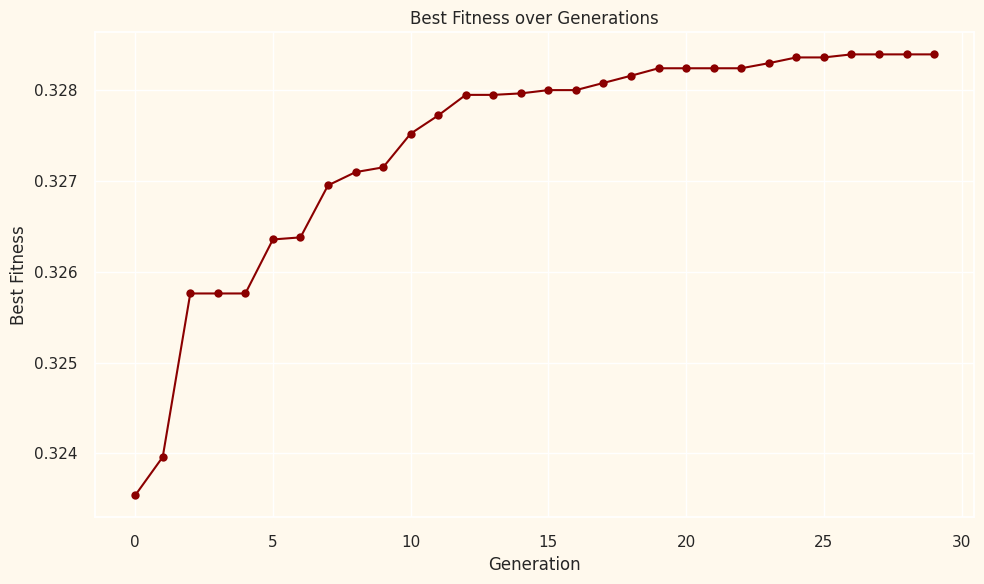

In [87]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# === Plot Fitness over Generations ===
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(fitness_history, color='darkred', marker='o', linestyle='-')  # Line plot with markers
plt.title("Best Fitness over Generations")  # Chart title
plt.xlabel("Generation")  # X-axis label
plt.ylabel("Best Fitness")  # Y-axis label
plt.grid(True)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()  # Display the plot


# ***Cluster Evaluation Using Internal Metrics***

In [88]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# نحسب التسميات (labels) من الحل النهائي
labels = assign_clusters(X, best_solution)

# نحسب المقاييس
silhouette = silhouette_score(X, labels)
davies_bouldin = davies_bouldin_score(X, labels)
calinski_harabasz = calinski_harabasz_score(X, labels)

# نطبع النتائج
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Score:", davies_bouldin)
print("Calinski-Harabasz Score:", calinski_harabasz)


Silhouette Score: 0.3283935967901816
Davies-Bouldin Score: 1.385983483794538
Calinski-Harabasz Score: 932.7603664295108


In [89]:
# === Comparison with KMeans ===
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED)
kmeans_labels = kmeans.fit_predict(X)
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_db = davies_bouldin_score(X, kmeans_labels)
kmeans_ch = calinski_harabasz_score(X, kmeans_labels)

print("\n📊 Evaluation Comparison:")
print("Metric".ljust(25), "Memetic".rjust(12), "KMeans".rjust(12))
print("-" * 50)
print("Silhouette Score".ljust(25), f"{silhouette:.4f}".rjust(12), f"{kmeans_silhouette:.4f}".rjust(12))
print("Davies-Bouldin Score".ljust(25), f"{davies_bouldin:.4f}".rjust(12), f"{kmeans_db:.4f}".rjust(12))
print("Calinski-Harabasz Score".ljust(25), f"{calinski_harabasz:.2f}".rjust(12), f"{kmeans_ch:.2f}".rjust(12))


📊 Evaluation Comparison:
Metric                         Memetic       KMeans
--------------------------------------------------
Silhouette Score                0.3284       0.3173
Davies-Bouldin Score            1.3860       1.3873
Calinski-Harabasz Score         932.76      1051.86


In [90]:
# Perplexity for t-SNE centroids visualization
tsne_centers_perplexity = 5 if N_CLUSTERS < 6 else min(30, N_CLUSTERS - 1)

In [91]:
from sklearn.manifold import TSNE

# === Visualization (PCA & t-SNE) ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_tsne = TSNE(n_components=2, perplexity=30, random_state=RANDOM_SEED).fit_transform(X)

In [92]:
# === Function to Plot Clusters + Centroids ===
def plot_clusters(X_2d, labels, centers_2d, title, method_name):
    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', marker='X', s=200, label='Centroids')
    plt.title(f'{title} ({method_name})')
    plt.xlabel(f'{method_name} 1')
    plt.ylabel(f'{method_name} 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

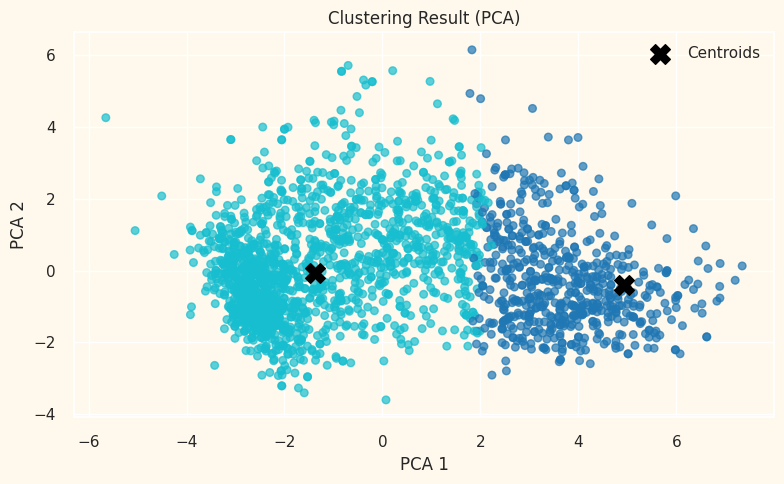

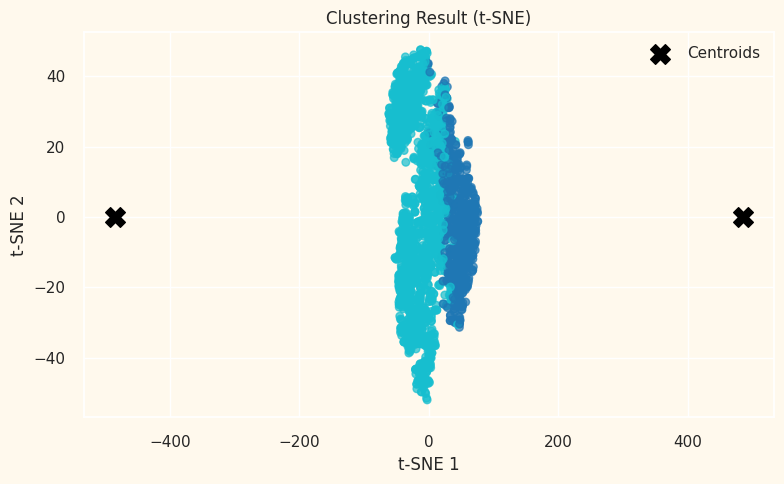

In [94]:
# === Plot Memetic Algorithm Clusters ===
labels_memetic = assign_clusters(X, best_solution)
centers_pca = pca.transform(best_solution)
#centers_tsne = TSNE(n_components=2, perplexity=tsne_centers_perplexity, random_state=RANDOM_SEED).fit_transform(best_solution)
tsne_centers_perplexity = min(1, best_solution.shape[0] - 1)
centers_tsne = TSNE(n_components=2, perplexity=tsne_centers_perplexity, random_state=RANDOM_SEED).fit_transform(best_solution)

plot_clusters(X_pca, labels_memetic, centers_pca, "Clustering Result", "PCA")
plot_clusters(X_tsne, labels_memetic, centers_tsne, "Clustering Result", "t-SNE")

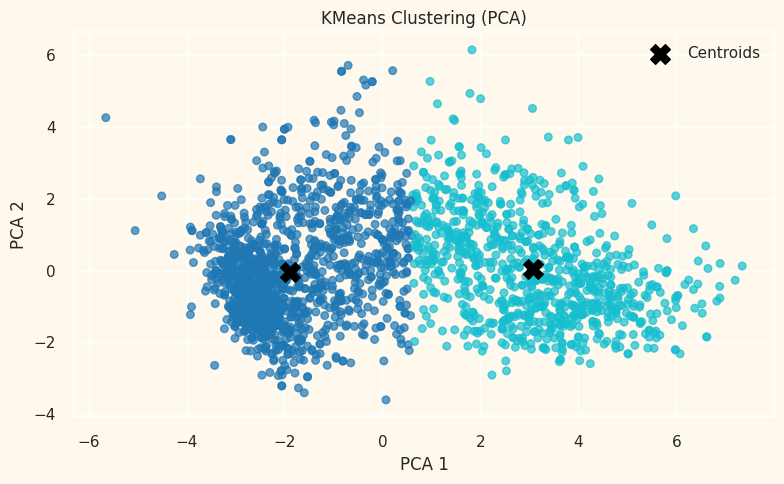

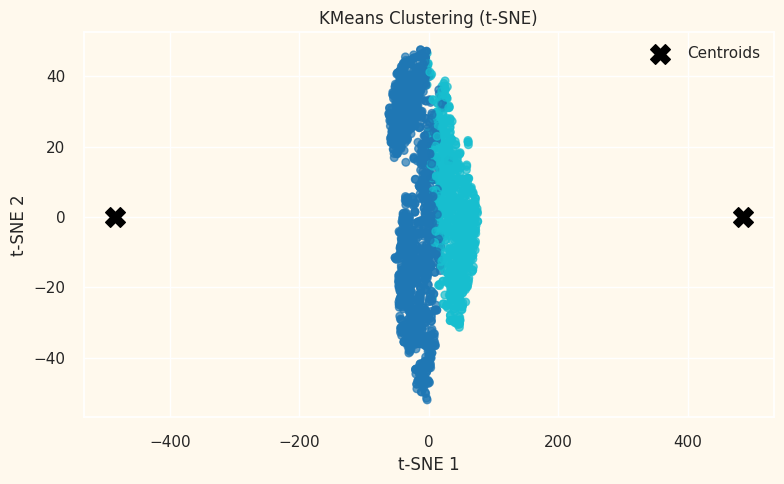

In [95]:
# === Plot KMeans Clusters ===
kmeans_centers_pca = pca.transform(kmeans.cluster_centers_)
#kmeans_centers_tsne = TSNE(n_components=2, perplexity=tsne_centers_perplexity, random_state=RANDOM_SEED).fit_transform(kmeans.cluster_centers_)
# أولاً: احسب قيمة الـ perplexity بحيث تكون مناسبة لعدد الكلاسترز
tsne_centers_perplexity = min(1, best_solution.shape[0] - 1)

# ثم: استخدمها في t-SNE لتصوير مراكز الكلاسترز
kmeans_centers_tsne = TSNE(n_components=2, perplexity=tsne_centers_perplexity, random_state=RANDOM_SEED).fit_transform(kmeans.cluster_centers_)

plot_clusters(X_pca, kmeans_labels, kmeans_centers_pca, "KMeans Clustering", "PCA")
plot_clusters(X_tsne, kmeans_labels, kmeans_centers_tsne, "KMeans Clustering", "t-SNE")